## Author: Mikołaj Nowak 151813

## Imports

In [1820]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from graphviz import Digraph #Add graphviz to path
#https://graphviz.org/download/

Visualization (just for me) how this data looks like

In [1821]:
file_path = "titanic-homework.csv"
data = pd.read_csv(file_path)
data = data.drop(columns=['Name', 'PassengerId'])
data['Age range'] = None
print(data.head())

   Pclass     Sex  Age  SibSp  Parch  Survived Age range
0       3    male   22      1      0         0      None
1       1  female   38      1      0         1      None
2       3  female   26      0      0         1      None
3       1  female   35      1      0         1      None
4       3    male   35      0      0         0      None


In [1822]:
print(data.describe())

           Pclass         Age       SibSp       Parch    Survived
count  100.000000  100.000000  100.000000  100.000000  100.000000
mean     2.390000   29.990000    0.730000    0.440000    0.400000
std      0.815197   17.166737    1.179411    0.967346    0.492366
min      1.000000    1.000000    0.000000    0.000000    0.000000
25%      2.000000   19.000000    0.000000    0.000000    0.000000
50%      3.000000   27.500000    0.000000    0.000000    0.000000
75%      3.000000   38.000000    1.000000    0.000000    1.000000
max      3.000000   78.000000    5.000000    5.000000    1.000000


Let's define the necessary functions for the **ID3 algorithm** as follows:

1. **`getEntropy(vector<bool> class)`**: Returns the entropy of the given class vector.
2. **`getConditionalEntropy(vector<bool> class, vector<data> attribute)`**: Returns the conditional entropy of the class vector with respect to the given attribute.
3. **`getInformationGain(vector<bool> class, vector<data> attribute)`**: Returns the information gain of the class vector when split by the given attribute.
4. **`getGainRatio(vector<bool> class, vector<data> attribute)`**: Returns the gain ratio of the class vector for the specified attribute.


## 1. Entropy

In [1823]:
def getEntropy(cl):
    if(len(cl) == 0):
        return 0
    zerosCount = 0
    onesCount = 0
    for value in cl:
        if value == 0:
            zerosCount += 1
        else:
            onesCount += 1
    probability0 = zerosCount/len(cl)
    probability1 = onesCount/len(cl)
    # Omit the log(0) scenario
    if(probability0 == 0 or probability1 == 0):
        return 0
    else:
        entropy = -(probability0*math.log(probability0,2) + probability1*math.log(probability1,2))
        return entropy

## 2. Conditional Entropy

In [1824]:
def getConditionalEntropy(cl, attribute):
    size = len(cl)
    # Create a dataframe with the class and the attribute for easier calculations
    df = pd.DataFrame()
    df["class"] = cl
    df["attribute"] = attribute

    unique_values = df["attribute"].unique()
    CondEntropy = 0
    for value in unique_values:
        attribute_value_subset = df[df["attribute"] == value]
        probability = len(attribute_value_subset) / size
        entropy = getEntropy(attribute_value_subset["class"])
        CondEntropy += probability * entropy

    return CondEntropy


## 3. Information Gain

In [1825]:
def getInformationGain(cl, attribute):
    return getEntropy(cl) - getConditionalEntropy(cl, attribute)

## 4. Gain Ratio
If we use Information Gain in the ID3 algorithm, it might prioritize 'Age' as the root node because of the high number of distinct values. This would lead to overfitting, as the algorithm would split too finely on this attribute

In [1826]:
def getGainRatio(cl, attribute):
    def IntrinsicInfo(attribute):
        size = len(attribute)
        df = pd.DataFrame()
        df["attribute"] = attribute
        counts = df["attribute"].value_counts()
        info = 0
        for count in counts:
            probability = count/size
            info -= probability*math.log(probability, 2)
        return info

    info = IntrinsicInfo(attribute)
    gain = getInformationGain(cl, attribute)
    if(info == 0):
        return 0
    gainRatio = gain/info
    return gainRatio

## 5. Problems with age (pro version: for 5.0)
Let's visualize the given data and see if we can divide the age into buckets that show clear thresholds between decisions.

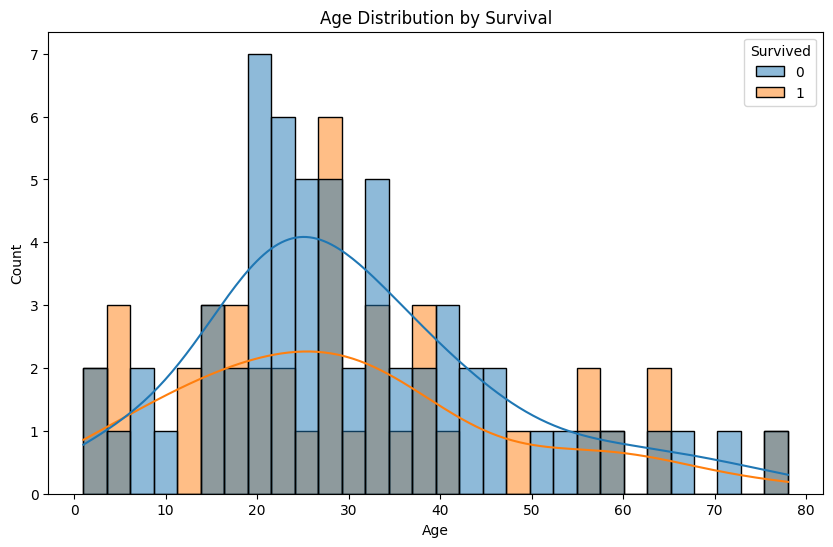

In [1827]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x="Age", hue="Survived", kde=True, bins=30)
plt.title("Age Distribution by Survival")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

Unfortunately, there are no clear boundaries, so we need to let the algorithm determine the best thresholds for the given scenario in each node.

## 6. ID3 algorithm
I already have a working code for graph visualization from one of my previous courses (Introduction to AI with Dr. Martyn). I will use this file for graph construction and visualization, making only minor modifications to accommodate non-binary attributes.

In [1828]:
class Node:
    def __init__(self, attr=None, children = None, value=None, decision=None):
        self.attr = attr  # The attribute to split on (e.g., 'Pclass', 'Sex')
        self.value = value  # The class label (e.g., male or female for 'Sex')
        self.decision = decision # Classifier
        self.children = children  # List to hold child nodes
        self.nodeId = 0
        self.threshold = 0

    def __call__(self, obj):
        if self.value is not None:
            return self.value
        
        for child in self.children:
            if obj[self.attr] == child.attr_value:
                return child(obj)
        return None

These functions are specifically for visualizing the decision tree. The **AddNode** function colors the tree as follows:

1. **Leaf Nodes:** Colored **<span style="color:red">red</span>** or **<span style="color:green">green</span>** depending on whether people survived or not. <span style="color:red">Red</span> indicates that people did not survive, while <span style="color:green">green</span> indicates survival.
2. **Internal Decision Nodes:** Colored **<span style="color:yellow">yellow</span>** to represent decision points in the tree where further splits are made.



In [1829]:
def getErrorRate(root, data):
    correct = 0
    for i in range(len(data)):
        row = data.iloc[i]
        correct += root(row) == row['Survived']
    return 1 - float(correct) / float(len(data))


def addNode(dgraph, node, data):
    if data is not None:
        clZeroCount = len(data[data['Survived'] == 0])
        clOneCount = len(data[data['Survived'] == 1])
        stats = f"Dead: {clZeroCount}\nAlive: {clOneCount}"
    else:
        stats = ""

    if node.decision is not None:  # Leaf node (terminal decision)
        nodeName = str(node.nodeId)
        nodeLabel = (
            stats
        )
        dgraph.node(nodeName, label=nodeLabel, fillcolor="green" if node.decision == 1 else "red", style="filled")

    else:  # Intermediate node
        nodeName = str(node.nodeId)
        nodeLabel = (
            "Attribute: "
            + str(node.attr) + "\n"
            + stats
        )
        dgraph.node(nodeName, label=nodeLabel, fillcolor="yellow", style="filled")

        if node.attr is not None:
            if(node.attr == "Age range"):
                data.loc[data['Age'] >= node.threshold, 'Age range'] = 'Above ' + str(node.threshold)
                data.loc[data['Age'] < node.threshold, 'Age range'] = 'Below ' + str(node.threshold)
            unique_values = data[node.attr].unique()
            for value in unique_values:
                filteredData = data[data[node.attr] == value] 

                for child in node.children:
                    if child.value == value:
                        childNodeName = str(child.nodeId)
                    
                        dgraph.edge(nodeName, childNodeName, label=str(value))
                        addNode(dgraph, child, filteredData)

    return nodeName


def addId(root):
    nodes = [root]
    nodeId = 0
    while nodes:
        node = nodes.pop(0)
        node.nodeId = nodeId
        nodeId += 1
        nodes.extend(node.children)


def printGraph(root, data=None, size=10, fileName="DecisionTree"):
    dgraph = Digraph(format="png", filename=fileName)
    dgraph.attr(size=str(size) + "," + str(size))
    dgraph.node_attr.update()
    addId(root)
    addNode(dgraph, root, data)
    display(dgraph)


We need a function that, based on the current data, returns the best parameter for splitting the decision tree. It calculates the greatest gain ratio, and if there is an attribute with many numerical values (like age, for example), it also returns the best threshold for dividing the tree based on this parameter.

In [1830]:
def maxArgGainRatio(data):
    max_gain = float('-inf')
    max_arg = None
    # Get attribute names from the DataFrame, excluding the target variable 'Survived'
    attributeNames = data.columns.drop("Survived")
    for attribute_name in attributeNames:
        if(attribute_name == "Age"):
            continue
        if(attribute_name == "Age range"):
            local_gain = 0
            # Get min and max age and check all thresholds
            min_age = data['Age'].min()
            max_age = data['Age'].max()
            best_threshold = min_age
            for threshold in range (min_age, max_age):
                data.loc[data['Age'] >= threshold, 'Age range'] = 'Above ' + str(threshold)
                data.loc[data['Age'] < threshold, 'Age range'] = 'Below ' + str(threshold)
                gain = getGainRatio(data["Survived"], data['Age range'])
                if gain > max_gain:
                    max_gain = gain
                    max_arg = attribute_name
                    best_threshold = threshold
                if(gain > local_gain):
                    local_gain = gain
        # Other 'normal' arguments
        gain = getGainRatio(data["Survived"], data[attribute_name])
        if gain > max_gain:
            max_gain = gain
            max_arg = attribute_name
    # Populate Age range with correct values
    if(max_arg == 'Age range'):
        data.loc[data['Age'] >= best_threshold, 'Age range'] = 'Above ' + str(best_threshold)
        data.loc[data['Age'] < best_threshold, 'Age range'] = 'Below ' + str(best_threshold)
    return max_arg, max_gain, best_threshold

Splitting the tree works as follows:

1. Find the best parameter (and optional threshold).
2. Split the data based on this threshold.
3. If the entropy is 0, mark this node as a leaf.
4. Otherwise, traverse further recursively.

In [1831]:
def splitTree(current_node, current_data):
    arg, gain, threshold = maxArgGainRatio(current_data)
    # Don't split further if there is no gain
    if gain == 0.0:
        return current_node

    unique_values = current_data[arg].unique()
    children = []

    for value in unique_values:
        split_data = current_data[current_data[arg] == value]
        amount = len(split_data)
        ones = len(split_data[split_data["Survived"] == 1])
        zeros = amount - ones

        if(zeros > 0 and ones > 0):
            childNode = Node(attr=None, children=[], value=value, decision = None)
            childNode = splitTree(childNode, split_data)
        else:
            if zeros > ones:
                decision = 0
            else:
                decision = 1
            childNode = Node(attr=None, children=[], value=value, decision=decision)
        children.append(childNode)     

    # Update the current node with the attribute and the list of children
    current_node.attr = arg
    current_node.children = children
    if(arg == "Age range"):
        current_node.threshold = threshold
    return current_node



def createTree(data):
    data = data.reset_index().drop("index", axis=1)
    root = Node(None, None, None, None)
    return splitTree(root, data) 

## 7. Display results

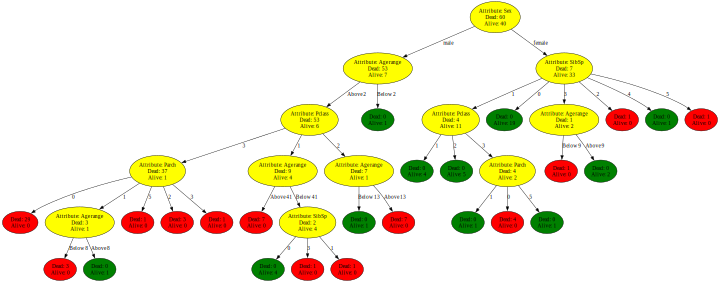

In [1832]:
root = createTree(data)
printGraph(root, data)

## 8. Summary

This decision tree is very likely to be overfitted, as we didn't introduce any validation dataset. Another flaw is that the age attribute was artificially aggregated, resulting in a discrete integer value. Had it been a double (a non-discrete value), this division based on a threshold would work much better, as there wouldn't be such edge cases, like two women aged 18 who (probably) just by accident did not survive, even though they share the same age.